In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from analiticsLabels import *

DATA = 'data'
V = 'v'
FOV = 'fov'
msg = 'msg'
OBS = 'obstacle'

files = [
    {
        DATA: pd.read_csv('data/3-tree-xvel-10-fov-60.csv'),
        FOV: '60',
        V: '1.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/3-tree-xvel-20-fov-60.csv'),
        FOV: '60',
        V: '2.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/3-tree-xvel-30-fov-60.csv'),
        FOV: '60',
        V: '3.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/3-tree-xvel-10-fov-30.csv'),
        FOV: '30',
        V: '1.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/3-tree-xvel-20-fov-30.csv'),
        FOV: '30',
        V: '2.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/3-tree-xvel-30-fov-30.csv'),
        FOV: '30',
        V: '3.0',
        OBS: 'tree'
    },
    {
        DATA: pd.read_csv('data/0-xvel-10-yvel-00-fov-30.csv'),
        FOV: '30',
        V: '1.0',
        OBS: 'building'
    },
    {
        DATA: pd.read_csv('data/0-xvel-20-yvel-00-fov-30.csv'),
        FOV: '30',
        V: '2.0',
        OBS: 'building'
    },
    {
        DATA: pd.read_csv('data/0-xvel-30-yvel-00-fov-30.csv'),
        FOV: '30',
        V: '3.0',
        OBS: 'building'
    },
    {
        DATA: pd.read_csv('data/0-xvel-10-yvel-00-fov-60.csv'),
        FOV: '60',
        V: '1.0',
        OBS: 'building'
    },
    {
        DATA: pd.read_csv('data/0-xvel-20-yvel-00-fov-60.csv'),
        FOV: '60',
        V: '2.0',
        OBS: 'building'
    },
    {
        DATA: pd.read_csv('data/0-xvel-30-yvel-00-fov-60.csv'),
        FOV: '60',
        V: '3.0',
        OBS: 'building'
    },
]

In [98]:
from collections import deque

class ActivationDecisionMaker(object):
    
    def __init__(self, vel, min_init=20, min_decision=6, threshold_constant=1):
        
        # Obtained from the offline graphs using np.lstsq
        w_means, w_stds = 0.14254784, 0.02400344
        
        self.report_activations = []
        self.report_thresholds = []
        self.report_decisions = []
        self.report_distance = []
        self.report_mean = []
        self.active_activations = deque(maxlen=15)
        self.previous_valid = None
        self.n = 0
        self.std = w_stds * vel
        self.mean = w_means * vel
        self._init = False
        self.decisions = deque(maxlen=min_decision)
        
        self.noise_mean = vel * 0.14662427
        self.noise_std = vel * 0.10710734

        self.min_init = min_init
        self.min_decision = min_decision
        self.threshold_constant = threshold_constant
        
    def check_init(self, activation):
        self.report_activations.append(self.mean)
        self.report_thresholds.append(np.nan)
        self.report_mean.append(self.mean)
        self.report_decisions.append(np.nan)
        self.report_distance.append(np.nan)
        if self.n >= self.min_init:
            self.previous_valid = activation
            self._init = True
            
    def update_stats(self, activation):
        # Increase n
        n = self.n + 1
        # Save old var and mean
        old_var = self.std ** 2
        old_mean = self.mean
        # New mean: multiply by n-1 to get the previous sum,
        # add the new activation, and divide by n
        mean = (self.mean * (n - 1) + activation) / n
        # New var: 
        # https://math.stackexchange.com/questions/102978/incremental-computation-of-standard-deviation
        var = ((float((n - 2)) / (n - 1) * old_var) + 
               1 / n * (activation - old_mean) ** 2)
        
        # Update class attributes
        self.n = n
        self.mean = mean
        self.std = np.sqrt(var)
        
    def is_outlier(self, activation, m=1, p=False):
        dist_from_mean = np.abs(activation - self.noise_mean)
        if p:
            print('Mean:       ', self.noise_mean)
            print('Activation: ', activation)
            print('Distance:   ', dist_from_mean)
            print('Check:      ', m * self.noise_std)
            print('Outlier:    ', dist_from_mean >= m * self.noise_std)
            
        return dist_from_mean >= m * self.noise_std
        
    def filter_single(self, activation):
        filt_act = activation
        
        if not self.is_outlier(filt_act):
            threshold = (self.mean + 
                         self.threshold_constant * self.std)

            return filt_act, threshold
        
        return False, False
    
    def make_decision(self, filt_act, threshold):
        self.decisions.append(filt_act >= threshold)
        if sum(self.decisions) == self.min_decision:
            self.report_decisions.append(filt_act)
            return True
        self.report_decisions.append(np.nan)
        return False
    
    def step(self, activation, distance=False):
        
        if self._init:
            filt_act, threshold = self.filter_single(activation)
            if filt_act:
                self.report_distance.append(distance)
                self.report_activations.append(filt_act)
                self.report_thresholds.append(threshold)
                self.report_mean.append(self.mean)
                self.update_stats(activation)
                decision = self.make_decision(filt_act, 
                                              threshold)
                return decision
                
        else:
            self.n += 1
            # Check whether we can initialise
            self.check_init(activation)
            
        return False
                    


In [100]:

def run_experiments(save=False, mean=False):
    for f in files:
        vel = float(f[V])
        dm = ActivationDecisionMaker(vel=vel)
        save_name = 'activation-alg-obstacle-' + f[OBS] + '-vel-' + f[V].replace('.', '') + '-fov-' + f[FOV] + '.pdf'
        msg = 'Approaching ' + f[OBS] +'. v=' + f[V] + ', FOV=' + f[FOV] + '.'

        activations = f[DATA][ACTIVATION]
        decisions = []


        for i, act in enumerate(activations):
            decision = dm.step(act, distance=f[DATA][POSITION][i])
            #print(decision)

        dist = -1 * np.array(dm.report_distance)

        plt.figure()
        plt.xlabel('Distance')
        plt.ylabel('Activation')
        plt.title(msg)
        plt.plot(dist, dm.report_activations, label='activation')
        plt.plot(dist, dm.report_decisions, label='stop decision')
        plt.plot(dist, dm.report_thresholds,'--', color='#5A5A5A', label='threshold')
        if mean:
            plt.plot(dist, dm.report_mean,'--', color='#A1A1A1', label='mean')
        plt.legend()
        
        if save:
            plt.savefig('figures/' + save_name)


IOError: [Errno 2] No such file or directory: 'figures/activation-alg-obstacle-tree-vel-10-fov-60.pdf'

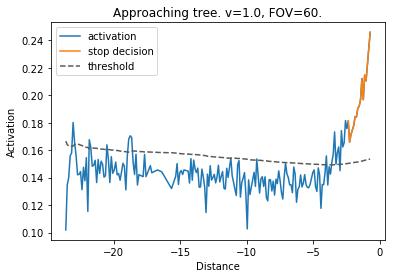

In [102]:
run_experiments(save=True)